## **Problem**

Predict energy efficiency related parameters for buildings given building features.

## **Dataset**
Link:
https://archive.ics.uci.edu/ml/datasets/energy+efficiency

The dataset has been generated using a simulation software for calculating the heating and cooling load depending on eight parameters X1,...,X8.

Number of instances: 768 -> small dataset: data augmentation will be performed

Features:
- X1:	Relative Compactness 
- X2:	Surface Area 
- X3:	Wall Area 
- X4:	Roof Area 
- X5:	Overall Height 
- X6:	Orientation 
- X7:	Glazing Area 
- X8:	Glazing Area Distribution

Targets:
- y1: Heating Load 
- y2: Cooling Load



## **Models**
All the models will be fully connected feedforward neural networks:

**Baseline**
- Input layer: 128 units
- Hidden layer: 128 units
- Output layer: 2 units

**Batch normalization**
- Same architecture as the baseline
- Batch normalization added

**Big model**
- Input layer: 256 units
- Hidden layer: 256 units
- Output layer: 2 units

**l2 model**
- Same architecture as the baseline
- l2 regularization added

**Dropout model**
- Same architecture as the big model
- dropout regularization added



                            


## **Data preprocessing**

In [0]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

#download the dataset
dataset_path = keras.utils.get_file("ENB2012_data.xlsx", "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx")
column_names = ['X1','X2','X3','X4','X5','X6','X7','X8','Y1','Y2'] 
raw_dataset = pd.read_excel(dataset_path, names=column_names)
dataset = raw_dataset.copy()

#split the training and test data
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#split features from labels
train_labels = train_dataset[['Y1','Y2']].copy()
train_dataset.pop('Y1')
train_dataset.pop('Y2')
test_labels = test_dataset[['Y1','Y2']].copy()
test_dataset.pop('Y1')
test_dataset.pop('Y2')

"""data augmentation: since the dataset is rather small, it will be augmented
                      by adding noise to the features and target variables"""

#augmented dataset
aug_train_dataset = train_dataset.copy()
aug_train_labels = train_labels.copy()

"""
#noise in the features: it does not pose any significant advantage
                        for the performance of the model
                        
noise = np.random.normal(0,0.05,train_dataset.shape)
pert_dataset = train_dataset + noise
noise = np.random.normal(0,0,train_labels.shape)
pert_labels = train_labels + noise
aug_train_dataset = aug_train_dataset.append(pert_dataset,ignore_index = True)
aug_train_labels = aug_train_labels.append(pert_labels,ignore_index = True)
print(aug_train_dataset.shape)
print(aug_train_labels.shape)
"""

#noise in the labels: it poses a significant advantage for the 
#                     performance of the model

noise = np.random.normal(0,0,train_dataset.shape)
pert_dataset = train_dataset + noise
noise = np.random.normal(0,0.1,train_labels.shape)
pert_labels = train_labels + noise
aug_train_dataset = aug_train_dataset.append(pert_dataset,ignore_index = True)
aug_train_labels = aug_train_labels.append(pert_labels,ignore_index = True)


#normalize data
normed_train_data = (aug_train_dataset - aug_train_dataset.mean()) / (aug_train_dataset.max() - aug_train_dataset.min())
normed_test_data = (test_dataset - test_dataset.mean()) / (test_dataset.max() - test_dataset.min())

train_labels = aug_train_labels.copy()


EPOCHS = 2000


## **Baseline**

In [0]:
#baseline model: fully connected NN without regularization
baseline=keras.Sequential([   
    layers.Dense(128, activation=tf.nn.relu,input_shape=[len(normed_train_data.keys())]),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(2)
  ])

optimizer = tf.train.RMSPropOptimizer(0.001)

baseline.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])



#train the model
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
base_history = baseline.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_data = (normed_test_data,test_labels),
                    verbose=1, shuffle = True, callbacks=[early_stop, PrintDot()])

#plot_history(history)
loss, mae, mse = baseline.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

## **Batch normalization**

In [0]:
#batch normalization model: fully connected NN with batch normalization
bn_model=keras.Sequential([   
    layers.Dense(128,input_shape=[len(normed_train_data.keys())],use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(128, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(2)
  ])

optimizer = tf.train.RMSPropOptimizer(0.001)

bn_model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])


#train the model
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
bn_history = bn_model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_data = (normed_test_data,test_labels),
                    verbose=1, shuffle = True, callbacks=[early_stop, PrintDot()])

#plot_history(history)
loss, mae, mse = bn_model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

## **Big model**

In [0]:
#big model: fully connected NN with more neurons per layer
big_model=keras.Sequential([   
    layers.Dense(256,activation=tf.nn.relu,input_shape=[len(train_dataset.keys())]),
    layers.Dense(256,activation=tf.nn.relu),
    layers.Dense(2)
  ])

optimizer = tf.train.RMSPropOptimizer(0.001)

big_model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])


#train the model
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
big_history = big_model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_data = (normed_test_data,test_labels), 
                    verbose=1,shuffle=True, callbacks=[early_stop, PrintDot()])

#plot_history(history)
loss, mae, mse = big_model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

## **l2 model**

In [0]:
#l2 model: fully connected NN with l2 regularization
l2_model=keras.Sequential([   
    layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.relu,input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dense(2)
  ])

optimizer = tf.train.RMSPropOptimizer(0.001)

l2_model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])


#train the model
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
l2_history = l2_model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_data = (normed_test_data,test_labels), 
                    verbose=1, shuffle=True,callbacks=[early_stop, PrintDot()])

#plot_history(history)
loss, mae, mse = l2_model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

## **Dropout**

In [0]:
#dropout model: big model with dropout
dpt_model=keras.Sequential([   
    layers.Dropout(0.1,input_shape=[len(train_dataset.keys())]),
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dropout(0.35),
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dropout(0.35),
    layers.Dense(2)
  ])

optimizer = tf.train.RMSPropOptimizer(0.001)

dpt_model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])


#train the model
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
dpt_history = dpt_model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_data = (normed_test_data,test_labels), 
                    verbose=1, shuffle=True,callbacks=[early_stop, PrintDot()])

#plot_history(history)
loss, mae, mse = dpt_model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

## **Predictions**

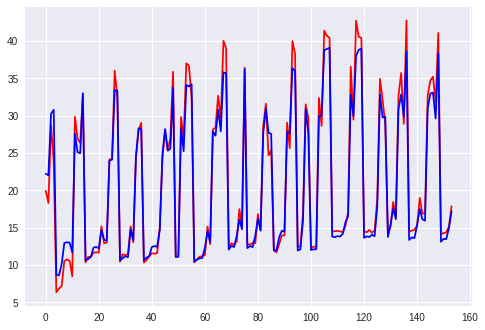

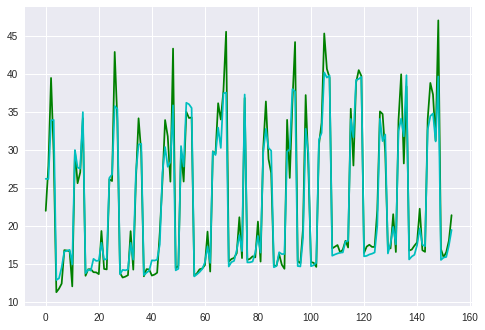

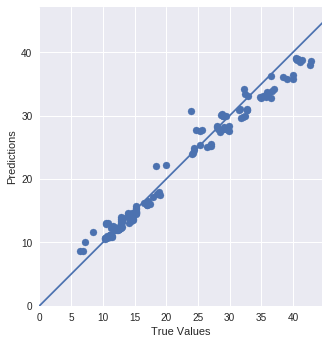

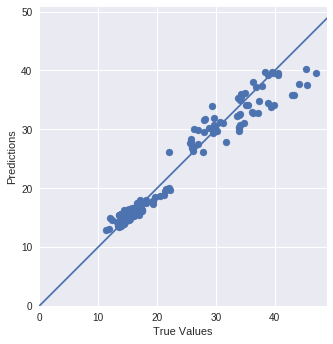

In [0]:
#plot predictions

test_predictions = dpt_model.predict(normed_test_data)

plt.figure()
plt.plot(test_labels[['Y1']].values,'r')
plt.plot(test_predictions[:,0],'b')


plt.figure()
plt.plot(test_labels[['Y2']].values,'g')
plt.plot(test_predictions[:,1],'c')

plt.figure()
plt.scatter(test_labels[['Y1']].values, test_predictions[:,0])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

plt.figure()
plt.scatter(test_labels[['Y2']].values, test_predictions[:,1])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


## **Training results**

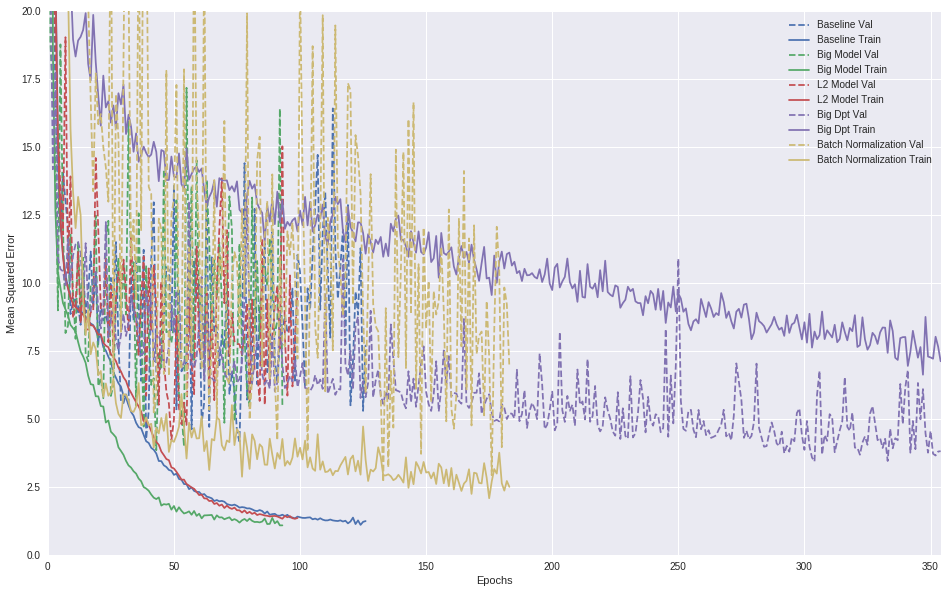

In [0]:
def plot_history(histories, key='mean_squared_error'):
  plt.figure(figsize=(16,10))
  
  m = 10
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')
    if max(history.epoch) > m:
       m=max(history.epoch)

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()
  
  plt.ylim([0,20])
  plt.xlim([0,m])
  plt.show()


plot_history([('baseline', base_history),('big model',big_history),
              ('l2 model',l2_history),('big dpt',dpt_history),
              ('batch normalization',bn_history)])